# Model Prediction Visualization

Visualize the model's output by providing:
1. The original (input) image
2. Binary mask identifying the damage and % of damage
3. Prediction probability heatmap

**NOTE:** Use the `sm-legacy` environment.

## Check GPU Support

In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPUs detected:", gpus)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

TF Version: 2.2.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Built with GPU support: True


## Imports and configurations

In [10]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

import random
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
# from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# TensorFlow and Keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Image augmentation
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

# Segmentation Models
import segmentation_models as sm

In [3]:
print(sm.framework())  # should output: "tf.keras"

tf.keras


## Helper functions for data visualization

In [40]:
def visualize(**images):
    """Plot images in one row with expanded, user-friendly titles."""
    # Mapping from keys to expanded titles
    title_map = {
        "image": "Input Image",
        "ground_truth_mask": "Ground Truth Mask",
        "gt_mask": "Ground Truth Mask",
        "predicted_mask": "Predicted Mask",
        "pr_mask": "Predicted Mask",
        "mask": "Mask"
    }

    n = len(images)
    plt.figure(figsize=(5 * n, 5))  # scalable size per image

    for i, (name, image) in enumerate(images.items()):
        title = title_map.get(name, " ".join(name.split("_")).title())
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(title)
        plt.imshow(image, cmap="gray" if image.ndim == 2 else None)

    plt.tight_layout()
    plt.show()

def denormalize(x):
    """Safely scale image to 0–1 for visualization."""
    x = np.array(x)  # just in case it's a tensor
    x_max = np.nanpercentile(x, 98)
    x_min = np.nanpercentile(x, 2)
    denom = x_max - x_min

    # avoid division by zero
    if denom == 0 or np.isnan(denom):
        return np.zeros_like(x)

    x = (x - x_min) / denom
    x = np.clip(x, 0, 1)
    return x

## Load Model and Build Architecture
**NOTE:** Please change the filepath for the model file below.

In [41]:
# Model parameters
BACKBONE = "resnet34"
INPUT_SHAPE = (320, 320, 3)
CLASSES = ["damage"]

n_classes = 1 if len(CLASSES) == 1 else len(CLASSES) + 1
activation = "sigmoid" if n_classes == 1 else "softmax"

# Define model
best_model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights=None,
    encoder_freeze=False,
    input_shape=INPUT_SHAPE,
    classes=n_classes,
    activation=activation
)

# Define loss and metrics
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.Precision(),
    sm.metrics.Recall(),
    sm.metrics.FScore(threshold=0.5),
]

# Compile and load weights
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=total_loss,
    metrics=metrics
)

# Best model will be based on iou metric
best_model.load_weights("../../models/best-val_iou.h5")

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def predict_mask(model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))
    img = img.astype(np.float32) / 255.0

    # Add batch dimension
    input_tensor = np.expand_dims(img, axis=0)  # shape (1, 320, 320, 3)

    # Predict
    pred_mask = model.predict(input_tensor)[0]  # shape (320, 320, 1)

    # Threshold to binary
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    # Calculate % Damage
    damage_percent = np.sum(binary_mask) / binary_mask.size * 100

    # Generate heatmap (probability map scaled to 0-255)
    prob_map = pred_mask[..., 0]
    heatmap = (cm.jet(prob_map)[:, :, :3] * 255).astype(np.uint8)  # RGB heatmap
    heatmap_overlay = cv2.addWeighted((img * 255).astype(np.uint8), 0.6, heatmap, 0.4, 0)

    return denormalize(img), prob_map, binary_mask[..., 0], heatmap_overlay, damage_percent

In [43]:
def visualize_prediction(model, image_path):
    original_img, prob_mask, binary_mask, heatmap_overlay, damage_percent = predict_mask(model, image_path)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Binary Mask at {damage_percent:.0f}% Damage")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

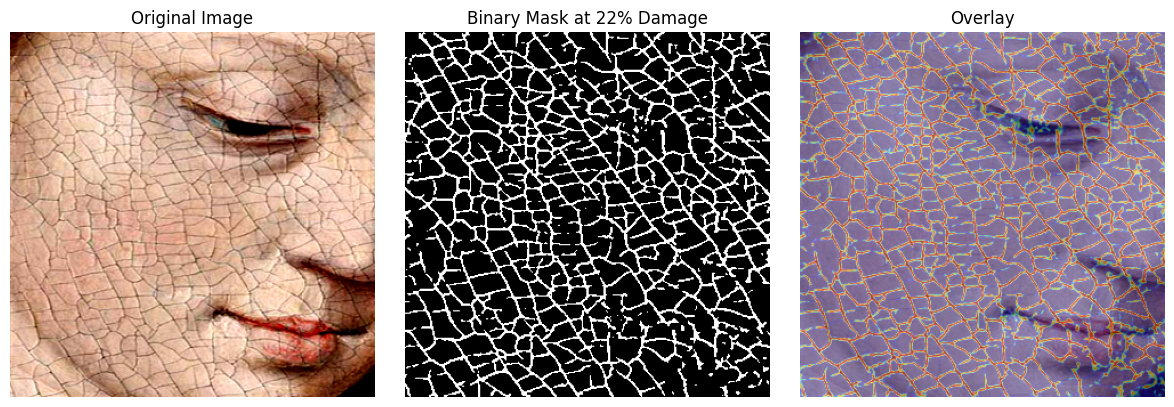

In [44]:
visualize_prediction(best_model, "../../data/cracked-portrait.jpg")

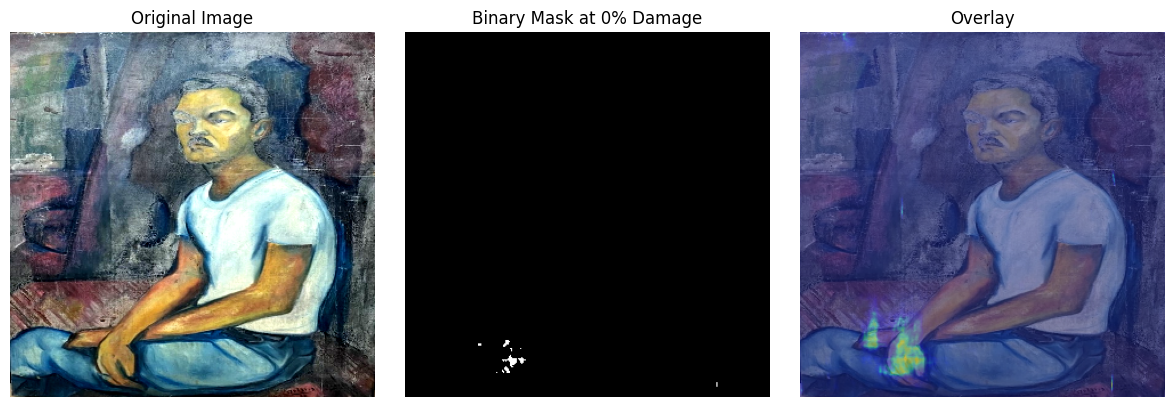

In [34]:
visualize_prediction(best_model, "../../data/leon-gallery-sample.jpg")

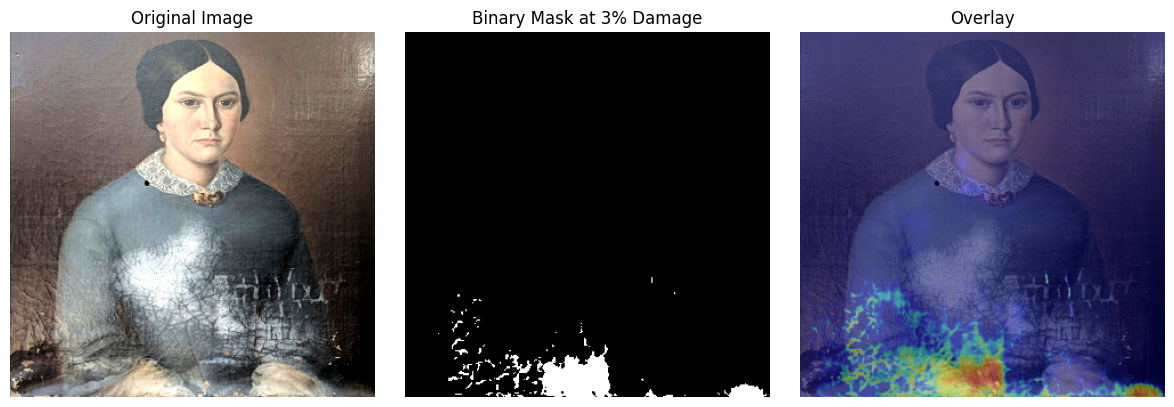

In [35]:
visualize_prediction(best_model, "../../data/fine-art-restoration-waterdamaged-bluelady-before.jpg")

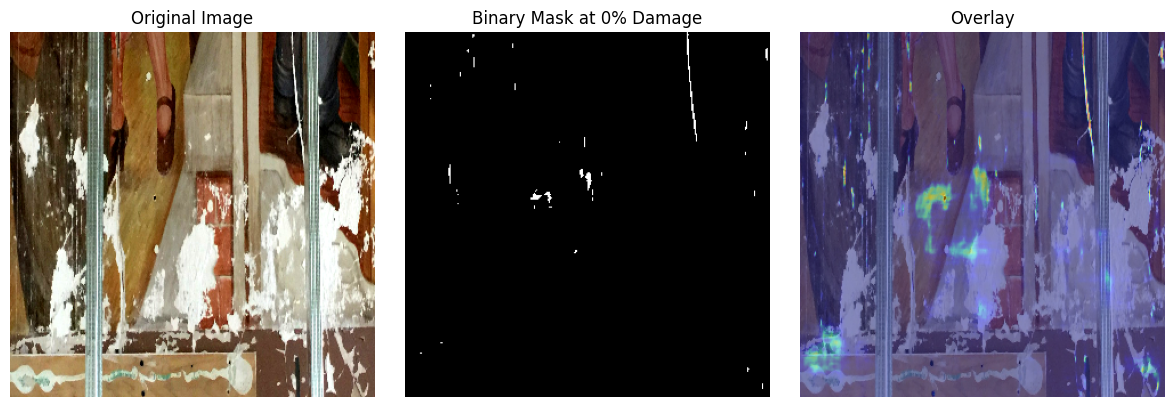

In [36]:
visualize_prediction(best_model, "../../data/different-types-of-art-damage-NB-min.jpg")

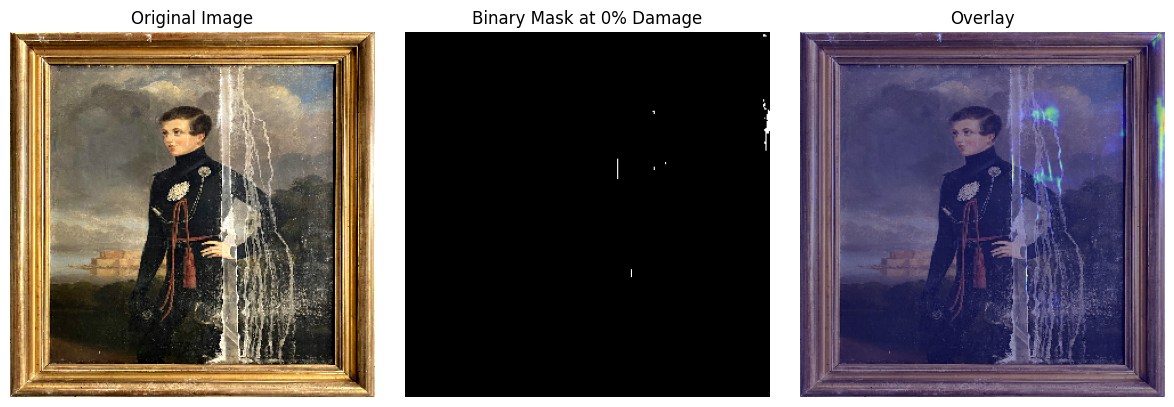

In [37]:
visualize_prediction(best_model, "../../data/fine-art-restoration-leak-damaged-boy-before.jpg")

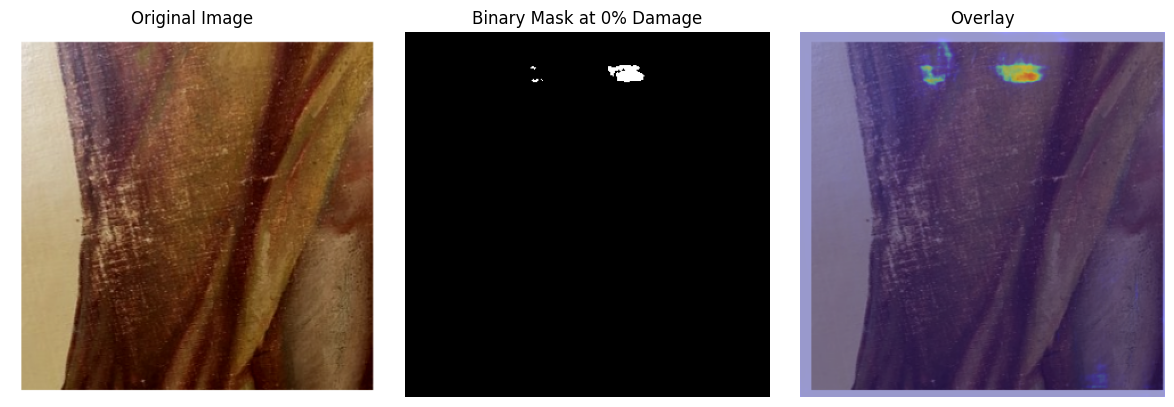

In [38]:
visualize_prediction(best_model, "../../data/scratch.png")